In [13]:
%pip install pandas matplotlib seaborn streamlit scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [24]:
# Cell 1: imports & helper
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Make plots look decent in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)

# helper
def show_head_and_info(df, n=5):
    print("SHAPE:", df.shape)
    display(df.head(n))
    print("\nINFO:")
    print(df.info())
    print("\nMISSING VALUE COUNTS (top columns):")
    print(df.isnull().sum().sort_values(ascending=False).head(20))


In [26]:
# Cell 2: load data
path = "./covid/covid_abstracts.csv" 

df = pd.read_csv(path, dtype=str)  # load everything as str initially to avoid dtype surprises
print("Loaded file:", path)
show_head_and_info(df)


Loaded file: ./covid/covid_abstracts.csv
SHAPE: (10000, 3)


,title,abstract,url
0,Real-World Experience with COVID-19 Including...,This article summarizes the experiences of COV...,https://pubmed.ncbi.nlm.nih.gov/35008137
1,Successful outcome of pre-engraftment COVID-19...,Coronavirus disease 2019 COVID-19 caused by...,https://pubmed.ncbi.nlm.nih.gov/35008104
2,The impact of COVID-19 on oncology professiona...,BACKGROUND COVID-19 has had a significant imp...,https://pubmed.ncbi.nlm.nih.gov/35007996
3,ICU admission and mortality classifiers for CO...,The coronavirus disease 2019 COVID-19 which ...,https://pubmed.ncbi.nlm.nih.gov/35007991
4,Clinical evaluation of nasopharyngeal midturb...,In the setting of supply chain shortages of na...,https://pubmed.ncbi.nlm.nih.gov/35007959



INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     10000 non-null  object
 1   abstract  10000 non-null  object
 2   url       10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB
None

MISSING VALUE COUNTS (top columns):
title       0
abstract    0
url         0
dtype: int64


In [27]:
# Cell 3: see column names and typical columns we expect
print("Columns:", df.columns.tolist())
# See sample unique values (for columns that likely exist)
for col in ['publish_time', 'publish_date', 'year', 'title', 'abstract', 'authors', 'journal', 'source_x','source']:
    if col in df.columns:
        print(f"\n--- Sample values for {col}:")
        print(df[col].dropna().unique()[:5])


Columns: ['title', 'abstract', 'url']

--- Sample values for title:
['Real-World Experience with COVID-19  Including Direct COVID-19 Antigen Testing and Monoclonal-Antibody Bamlanivimab in a Rural Critical Access Hospital in South Dakota'
 'Successful outcome of pre-engraftment COVID-19 in an HCT patient  impact of targeted therapies and cellular immunity'
 'The impact of COVID-19 on oncology professionals-one year on  lessons learned from the ESMO Resilience Task Force survey series'
 'ICU admission and mortality classifiers for COVID-19 patients based on subgroups of dynamically associated profiles across multiple timepoints'
 'Clinical evaluation of nasopharyngeal  midturbinate nasal and oropharyngeal swabs for the detection of SARS-CoV-2']

--- Sample values for abstract:
['This article summarizes the experiences of COVID-19 patients diagnosed and treated at Faulkton Area Medical Center  FAMC   a rural critical access facility in South Dakota  during three periods of COVID-19  Retr

In [28]:
# Cell 4: working copy and missing summary
df_clean = df.copy()
# count missing in important columns
for col in ['title', 'abstract', 'publish_time', 'publish_date', 'authors', 'journal', 'source_x', 'source']:
    if col in df_clean.columns:
        print(col, "missing:", df_clean[col].isnull().sum())


title missing: 0
abstract missing: 0


In [29]:
# Cell 5: robust datetime parsing
date_cols = [c for c in ['publish_time','publish_date','date'] if c in df_clean.columns]
if date_cols:
    # create a unified column 'pub_date' trying each candidate
    df_clean['pub_date'] = None
    for c in date_cols:
        # coerce errors -> NaT
        series = pd.to_datetime(df_clean[c], errors='coerce', infer_datetime_format=True)
        # fill pub_date where still null
        df_clean['pub_date'] = pd.to_datetime(df_clean['pub_date']).combine_first(series)
else:
    # if no date cols, create NaT column
    df_clean['pub_date'] = pd.NaT

# final conversion & extract year
df_clean['pub_date'] = pd.to_datetime(df_clean['pub_date'], errors='coerce')
df_clean['year'] = df_clean['pub_date'].dt.year
print("Year distribution (counts):")
print(df_clean['year'].value_counts(dropna=False).sort_index())


Year distribution (counts):
year
NaN    10000
Name: count, dtype: int64


In [30]:
# Cell 6: word counts
def word_count(text):
    if pd.isna(text): return 0
    # simple split on whitespace after stripping
    return len(str(text).split())

df_clean['title_word_count'] = df_clean.get('title', pd.Series([""]*len(df_clean))).fillna("").astype(str).apply(word_count)
df_clean['abstract_word_count'] = df_clean.get('abstract', pd.Series([""]*len(df_clean))).fillna("").astype(str).apply(word_count)

print("Title word count stats:")
print(df_clean['title_word_count'].describe())
print("\nAbstract word count stats:")
print(df_clean['abstract_word_count'].describe())

# Drop rows that have neither title nor abstract (not useful for our analysis)
keep_mask = (df_clean['title_word_count'] > 0) | (df_clean['abstract_word_count'] > 0)
print("\nRows before:", len(df_clean))
df_clean = df_clean[keep_mask].reset_index(drop=True)
print("Rows after dropping entries with no title & no abstract:", len(df_clean))


Title word count stats:
count    10000.000000
mean        14.957900
std          5.065303
min          3.000000
25%         11.000000
50%         15.000000
75%         18.000000
max         39.000000
Name: title_word_count, dtype: float64

Abstract word count stats:
count    10000.000000
mean       226.400900
std         81.352513
min         40.000000
25%        172.000000
50%        223.000000
75%        271.000000
max        799.000000
Name: abstract_word_count, dtype: float64

Rows before: 10000
Rows after dropping entries with no title & no abstract: 10000


In [31]:
# Cell 7: save a cleaned version
out_path = "./covid/metadata_clean.csv"
df_clean.to_csv(out_path, index=False)
print("Cleaned CSV saved to:", out_path)


Cleaned CSV saved to: ./covid/metadata_clean.csv


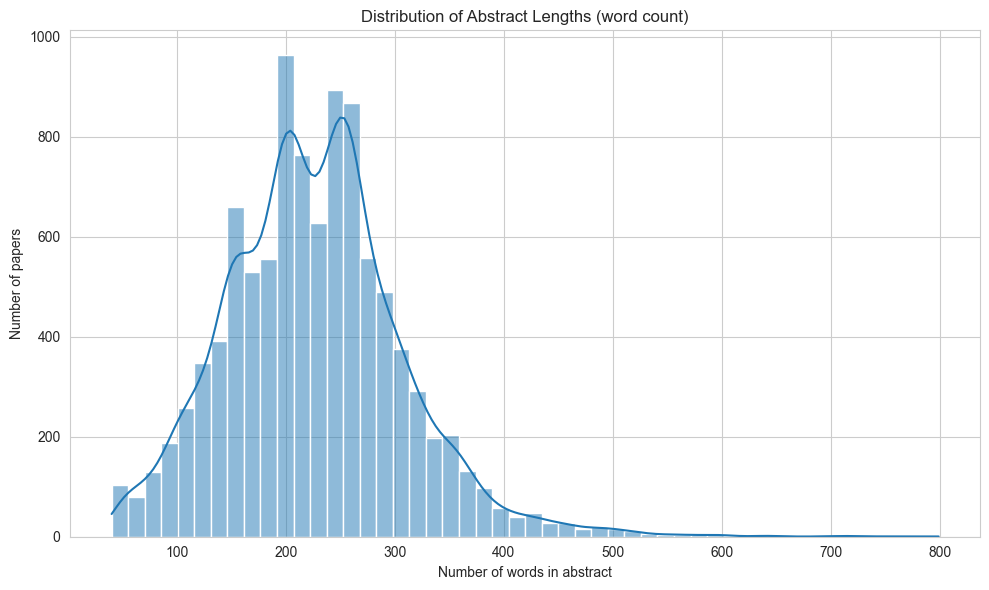

In [34]:
# Distribution of abstract word counts
plt.figure(figsize=(10,6))
sns.histplot(df_clean['abstract_word_count'], bins=50, kde=True)
plt.title("Distribution of Abstract Lengths (word count)")
plt.xlabel("Number of words in abstract")
plt.ylabel("Number of papers")
plt.tight_layout()
plt.show()


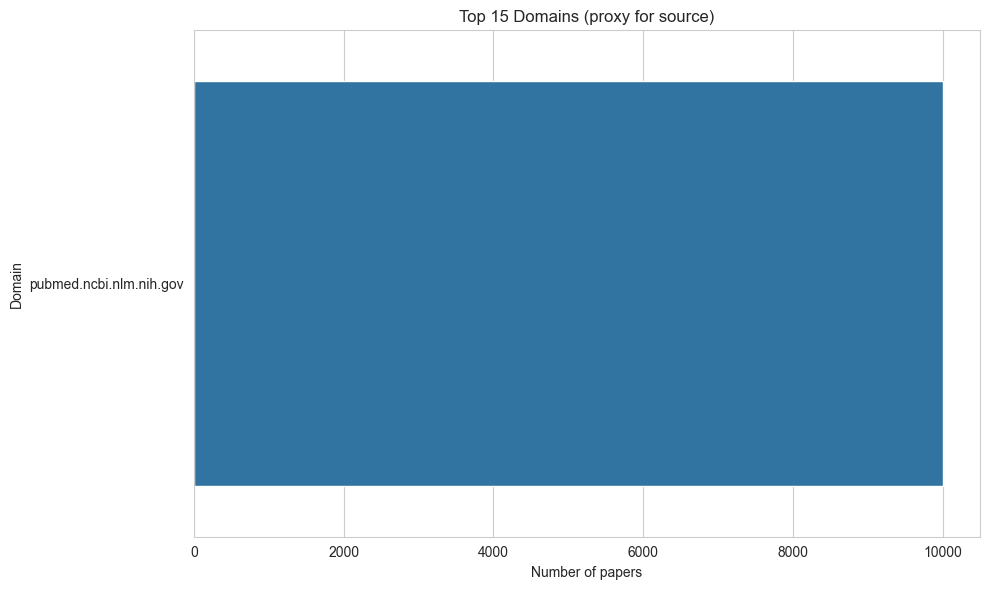

In [35]:
# Cell 9: top nespapers
# possible column names
from urllib.parse import urlparse

df_clean['domain'] = df_clean['url'].apply(lambda x: urlparse(str(x)).netloc)
top_domains = df_clean['domain'].value_counts().head(15)

plt.figure(figsize=(10,6))
sns.barplot(y=top_domains.index, x=top_domains.values)
plt.title("Top 15 Domains (proxy for source)")
plt.xlabel("Number of papers")
plt.ylabel("Domain")
plt.tight_layout()
plt.show()



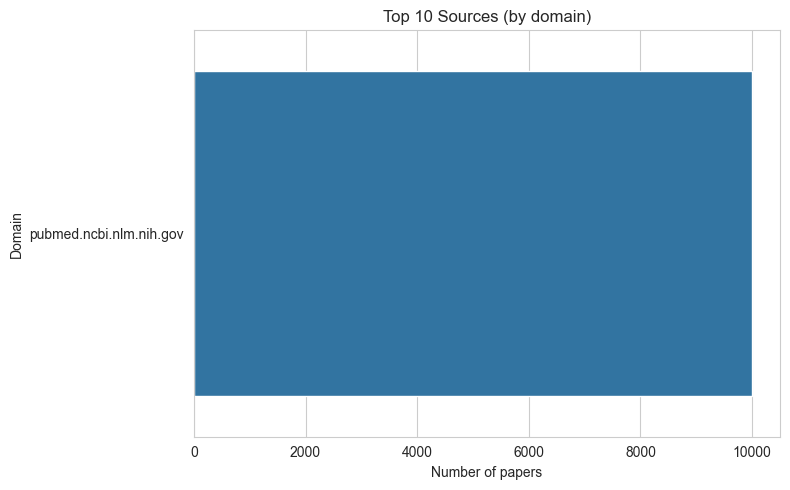

In [37]:
# Cell 10 : source distribution from domain
src_counts = df_clean['domain'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=src_counts.values, y=src_counts.index)
plt.title("Top 10 Sources (by domain)")
plt.xlabel("Number of papers")
plt.ylabel("Domain")
plt.tight_layout()
plt.show()


In [38]:
# Cell 11: most frequent words
# build a small stopword set
stopwords = set([
    'the','and','of','in','a','for','on','with','to','from','by','an','is','are','using','use','at','via','study','studies',
    'covid','covid-19','covid19','sars-cov-2','sars','coronavirus'   # we likely want to exclude these to find informative words
])

titles = df_clean.get('title', pd.Series([""]*len(df_clean))).fillna("").astype(str)
words = Counter()
pattern = re.compile(r"[A-Za-z0-9']+")
for t in titles:
    for w in pattern.findall(t.lower()):
        if w in stopwords: 
            continue
        if len(w) <= 2: 
            continue
        words[w] += 1

most_common = words.most_common(30)
print("Top title words (word, count):")
print(most_common)


Top title words (word, count):
[('pandemic', 2096), ('during', 1805), ('cov', 1721), ('patients', 1171), ('health', 880), ('impact', 660), ('among', 647), ('care', 637), ('infection', 624), ('analysis', 548), ('vaccine', 545), ('review', 531), ('based', 528), ('disease', 518), ('vaccination', 454), ('case', 432), ('clinical', 410), ('associated', 361), ('after', 339), ('risk', 324), ('against', 307), ('mental', 297), ('hospital', 290), ('cross', 288), ('severe', 273), ('factors', 273), ('acute', 271), ('healthcare', 267), ('response', 260), ('between', 256)]
